Demo for comparison betweeen IMERG_lateV6 (0.1s* 0.1) and MRMS (0.01 * 0.01) around 16:30 May 16, 2015 -- The Severe Weather Outbreak (EF3 Tornado)

1. Access and read data in cloud

In [2]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# # add path to environment in case of plot error
# import os
# os.environ['PROJ_LIB']=r'/home/user/.conda/envs/venvname/share/proj' # path to the proj4 folder.
# os.environ['GDAL_DATA']=r'/home/user/.conda/envs/venvname/share' # path to the proj4 folder.

# Direct access
import s3fs
import earthaccess as ea
import fsspec

# datetime
import datetime as dt

# api to read files: possible packages to use
# import xarray as xr # for netcdf
import h5py  # for hdf5
import gzip  # for .gz to decompress the file

# data process
import numpy as np
import pandas as pd

# plotting using self-defined functions for better visualization
from plot_function import ndarry_mask  # mask the array
from plot_function import map_plot  # plot the map
import matplotlib.pyplot as plt
import seaborn as sns  # package for statistic data visualization

In [3]:
auth = ea.login(strategy="netrc", persist=True) # use 'interactive' strategy the first time to log in

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 11/09/2023
Using .netrc file for EDL


In [4]:
#### dataset1 in ASCII format with compression ####

# step1: provdie the daac name and short name of dataset
    # define the name of daac and dataset
DAAC1 = 'GES_DISC'
ssh_short_name1 = "GPM_3IMERGHHL" # short name of dataset. 

# step2: get links #
results1 = ea.search_data(
    short_name=ssh_short_name1,
    cloud_hosted=True,
    temporal=("2015-05-16", "2015-05-17"),
)

    # data_link list
https_links1 = []  # external link, todo: find ways to directly access data using external link
s3_links1 = []  # s3 link to directly accessing  data in AWS

for granule in results1:
    https_links1.extend(granule.data_links(access="on_prem"))
    s3_links1.extend(granule.data_links(access="direct"))
    
# step3: select proper links for use (similar part to what we did when we worked in local enviroment)

# step4: get credentials and open files with credentials #
s3_fs1 = ea.get_s3fs_session(DAAC1) # valid in one hour, need to refresh automatically for longer access

#### read hdf5 data ####
# open files with s3 links, works only in AWS #
with s3_fs1.open(s3_links1[33], mode='rb') as f1: # open files with https links : 4:30-5:00pm
    with h5py.File(f1) as hdf5:
        lon_gpm = hdf5['Grid']['lon'][:]
        lat_gpm = hdf5['Grid']['lat'][:]
        date_time = hdf5['Grid']['time_bnds'][:]
        precip_gpm = hdf5['Grid']['precipitationCal'][:]
        
precip_gpm = precip_gpm[0,:,:]
precip_gpm[precip_gpm == -9999.9] = np.nan
precip_gpm[precip_gpm == 0] = np.nan
precip_gpm = np.transpose(precip_gpm)

LON_gpm, LAT_gpm = np.meshgrid(lon_gpm,lat_gpm)

Granules found: 49


In [5]:
#### dataset2 in ASCII format with compression ####

# step1: provdie the daac name and short name of dataset
    # define the name of daac and dataset
ssh_short_name2 = "gpmmrms" # short name of dataset. 

# step2: get links #
results2 = ea.search_data(
    short_name=ssh_short_name2,
    cloud_hosted=True,
    temporal=("2015-05-16", "2015-05-17"),
)

    # data_link list
https_links2 = []  # external link, todo: find ways to directly access data using external link
s3_links2 = []  # s3 link to directly accessing  data in AWS

for granule in results2:
    https_links2.extend(granule.data_links(access="on_prem"))
    s3_links2.extend(granule.data_links(access="direct"))
    
# step3: select proper links for use (similar part to what we did when we worked in local enviroment)

# step4: get credentials and open files with credentials #
s3_fs2 = ea.get_fsspec_https_session() 

#### read data under zip file (.gz)####
# open files with https links, works both in and out AWS #
with s3_fs2.open(https_links2[58], mode='rb') as f2: # open files with https links: 4:44pm
    with gzip.open(f2, 'rb') as data_ori:  # decompress .gz files
        precip_mrms = np.loadtxt(data_ori,skiprows = 6)  # read interested dataset
        
with s3_fs2.open(https_links2[58], mode='rb') as f2: # open files with https links
    with gzip.open(f2, 'rb') as data_ori:  # decompress .gz files
        datainfo = pd.read_csv(data_ori, header=None)[:6]  # read coordinate information
        coor_info = datainfo.iloc[0:6, 0].str.split(' ', expand=True) # split coordinate information

precip_mrms[precip_mrms == -999.] = np.nan
precip_mrms[precip_mrms == 0.] = np.nan
        
# get the coordinate information
x0 = float(coor_info.iloc[2, 1])
xn = x0 + (float(precip_mrms.shape[1])-1) * float(coor_info.iloc[4, 1])
x_coor = np.round(np.linspace(np.round(x0,2),np.round(xn,2),precip_mrms.shape[1]),2)

y0 = float(coor_info.iloc[3, 1])+ (float(precip_mrms.shape[0])-1) * float(coor_info.iloc[4, 1])
yn = y0 - (float(precip_mrms.shape[0])-1) * float(coor_info.iloc[4, 1])
y_coor = np.round(np.linspace(np.round(y0,2),np.round(yn,2),precip_mrms.shape[0]),2)

LON_mrms, LAT_mrms = np.meshgrid(x_coor,y_coor)

Granules found: 76


2. Matching grids: Match grids in MRMS to GPM grids. Treat the GPM grids as the center and match all grids in MRMRS that are within 0.1 degree to the center. 
zoom_region = [-130, -60, 20, 55]

In [6]:
index_region = list(zip(*np.where((LON_gpm >=-105) & (LON_gpm <= -95) & (LAT_gpm >=30) & (LAT_gpm <=40))))  # grids for seleceted region

In [7]:
index_nan_gpm = list(zip(*np.where(~np.isnan(precip_gpm))))
index_nan_mrms = list(zip(*np.where(~np.isnan(precip_mrms))))

for_index = list(set(index_nan_gpm) & set(index_region))

In [8]:
#### main thread for matching ####

pair_precip = pd.DataFrame()

for i in range(len(for_index)):
    precip_gpm_i = precip_gpm[for_index[i]]  # get precip grid for GPM
    center_grid = [LON_gpm[for_index[i]],LAT_gpm[for_index[i]]]  # create the coordinate for the center

    distance_matrix = np.sqrt((LON_mrms-center_grid[0])**2 + (LAT_mrms-center_grid[1]) ** 2)  # calcualte distance matrix for MRMS
    index_search = list(zip(*np.where(distance_matrix<=0.1)))  # locate the matached grid in MRMS
    index_search = list(set(index_search) & set(index_nan_mrms))  # delete the nan girids
    index_list = [list(i) for i in index_search]  # convert the coordinate format to a proper format for index searching
    index_list = np.transpose(index_list)
    
    if len(index_list)==0:
        continue
    
    precip_mrms_i = precip_mrms[index_list[0],index_list[1]]  # find the matched grid in MRMS
    distance = distance_matrix[index_list[0],index_list[1]]

    pair_precip_i = pd.DataFrame({'GPM' : precip_gpm_i, 'MRMS' : precip_mrms_i, 'Dist':distance})
    pair_precip = pd.concat([pair_precip,pair_precip_i])

In [9]:
pair_precip

,GPM,MRMS,Dist
0,1.36,0.24,0.072800
1,1.36,0.60,0.070711
2,1.36,0.49,0.060827
3,1.36,0.65,0.042427
4,1.36,3.53,0.078103
...,...,...,...
83,0.01,0.12,0.089441
84,0.01,0.36,0.078101
85,0.01,0.26,0.042425
86,0.01,0.14,0.019997


In [12]:
pair_precip['error'] = pair_precip['GPM']-pair_precip['MRMS']

3. Hotmap plot

<Figure size 1200x1200 with 0 Axes>

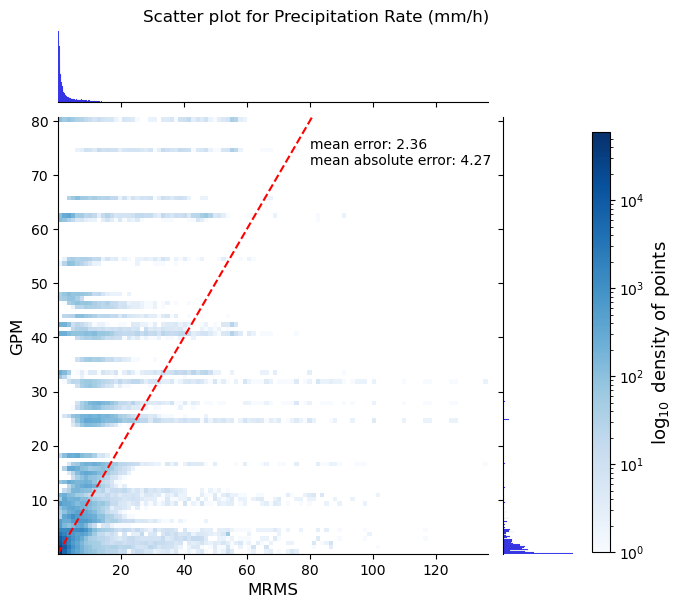

In [21]:
varname = 'Precipitation Rate (mm/h)'
df_plot = pair_precip
var1 = 'MRMS'
var2 = 'GPM'
color_hist = 'blue'
color_cmp = 'Blues'

fig = plt.figure(figsize=(12,12))

joint_kws = dict(bins=100)
# fig = plt.figure(figsize=(16,16))

x = np.linspace(0,150,100)
y = np.linspace(0,150,100)

mean_i = np.mean(df_plot['error'])
MAE_i = np.mean(np.abs(df_plot[var2]-df_plot[var1]))

ax1 = sns.jointplot(data = df_plot, x=var1, y=var2, kind='hist', edgecolor = None, color = color_hist, joint_kws = joint_kws)
# ax1.ax_joint.axhline(y=0, color = 'r', linestyle = 'dashed')
# ax1.ax_joint.plot(x[1:],y,color = 'b')
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)
plt.hist2d(df_plot[var1],df_plot[var2],bins=100, norm='log',cmap=color_cmp)
plt.title('Scatter plot for {}'.format(varname),y=1.2,x=0.6)
plt.ylabel(var2,fontsize=12)
plt.xlabel(var1,fontsize=12)
plt.text(80,75,'mean error: {}'.format(round(mean_i,2)))
plt.text(80,72,'mean absolute error: {}'.format(round(MAE_i,2)))
# plt.axhline(y=0,color = 'black', linestyle = 'dashed')
plt.plot(x,y,color = 'red', linestyle = 'dashed')

cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label(r'$\log_{10}$ density of points',fontsize=13)
plt.show()

<Figure size 1200x1200 with 0 Axes>

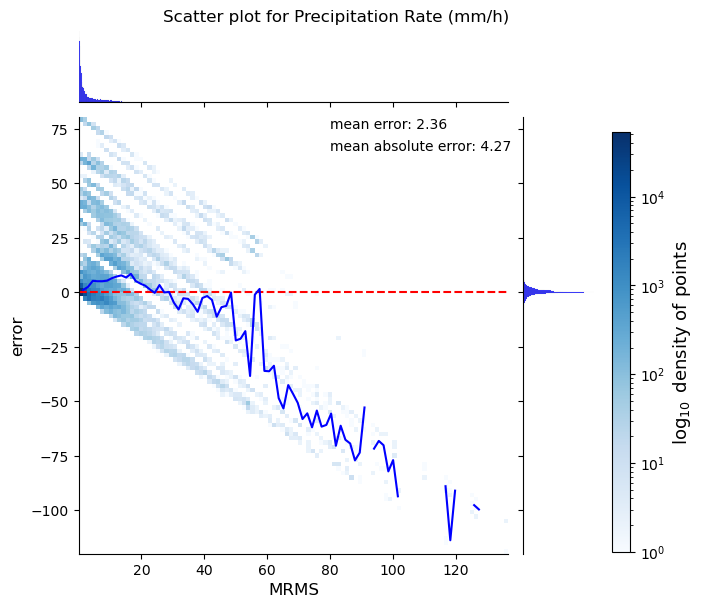

In [20]:
varname = 'Precipitation Rate (mm/h)'
df_plot = pair_precip
var1 = 'MRMS'
var2 = 'error'
color_hist = 'blue'
color_cmp = 'Blues'

fig = plt.figure(figsize=(12,12))

joint_kws = dict(bins=100)
# fig = plt.figure(figsize=(16,16))

x = np.linspace(0,150,100)
y = []
for i in range(len(x)-1):
    y.append(np.mean(df_plot.loc[(df_plot[var1] >= x[i]) & (df_plot[var1] < x[i+1]),
                            var2]))

mean_i = np.mean(df_plot['error'])
MAE_i = np.mean(np.abs(df_plot['error']))

ax1 = sns.jointplot(data = df_plot, x=var1, y=var2, kind='hist', edgecolor = None, color = color_hist, joint_kws = joint_kws)
# ax1.ax_joint.axhline(y=0, color = 'r', linestyle = 'dashed')
# ax1.ax_joint.plot(x[1:],y,color = 'b')
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)
plt.hist2d(df_plot[var1],df_plot[var2],bins=100, norm='log',cmap=color_cmp)
plt.title('Scatter plot for {}'.format(varname),y=1.2,x=0.6)
plt.ylabel(var2,fontsize=12)
plt.xlabel(var1,fontsize=12)
plt.text(80,75,'mean error: {}'.format(round(mean_i,2)))
plt.text(80,65,'mean absolute error: {}'.format(round(MAE_i,2)))
plt.axhline(y=0,color = 'red', linestyle = 'dashed')
plt.plot(x[1:],y,color = 'blue')

cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label(r'$\log_{10}$ density of points',fontsize=13)
plt.show()